In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import math 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

## Obtain

In [5]:
housing = pd.read_csv('kc_house_data.csv')
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [6]:
housing.shape

(21597, 21)

## Scrub

In [7]:
#to drop extra id column
housing = housing.drop('id', axis = 1)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

I feel that because waterfront is categorical (0 being not waterfront and 1 being waterfront) it will be apt to replace null values in waterfront with 0, assuming that if the properties were waterfront, they would be otherwise noted. 

Similarly to view, the view column denotes viewing, and if none are noted, I feel that the null value can also be replaced with 0. 

As for yr_renovated, I have taken a similar thought process, to assume that if no renovation year is noted, that no renovation has taken place, and that value can be replaced with 0. 

In [8]:
#replacing null values in yr_renovated, waterfront, and view with 0:
housing['waterfront'].fillna(0, inplace = True)
housing['yr_renovated'].fillna(0, inplace = True)
housing['view'].fillna(0, inplace = True)

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  float64
 8   view           21597 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [9]:
housing.sqft_basement.describe()

count     21597
unique      304
top         0.0
freq      12826
Name: sqft_basement, dtype: object

In [10]:
#to remove ? values from sqft_basement: 
def remove_mark(q):
    if q == '?':
        return 0  
    else:
        return q
    
housing['sqft_basement'] = housing.sqft_basement.map(lambda x: remove_mark(x))

#to convert sqft_basement to a float
housing['sqft_basement'] = housing['sqft_basement'].astype(float)

#to convert date to datetime 
housing['date'] = pd.to_datetime(housing.date)



In [11]:
#All null values are removed, and the housing dataframe is ready to be explored. 

## Explore

In [12]:
housing.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,3.409825,7.657915,1788.596842,285.716581,1970.999676,68.758207,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,439.819830,29.375234,364.037499,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Immediate observations: 
1. max bedrooms of 33 is abnormal and likely a typo, judging by the max sqft_living. 
2. waterfront, condition, and grade all seem to be categorical.

In [13]:
#replacing the 33 bedrooms value with the bedroom mean which is 3, which is close to the mean of 3.37, but also 
#describes a whole number, similarly to all other values
housing.loc[housing['bedrooms'] == 33, 'bedrooms'] = 3

## 1. Checking for colinearity 

In [14]:
#making a copy of the data without the price -y value-
housing_pred = housing.drop('price', axis = 1)

#checking for significant correlations between predictors
df=housing_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns into a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc <1.1)]

,cc
pairs,
"(bedrooms, bedrooms)",1.000000
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(grade, sqft_above)",0.756073
"(bathrooms, sqft_living)",0.755758


1. sqft_living correlates with sqft_above, grade, sqft_living15, and bathrooms

2. sqft_above correlates with sqft_living, and grade

3. grade correlates with sqft_living and sqft_above

4. bathrooms correlates with sqft_living

Before deciding which colinear features to eliminate, I want to take a look at which variables most drive the price, so that I can split off these variables to create a model that sets price as the y axis.

Text(0.5, 1.0, 'Price Correlations')

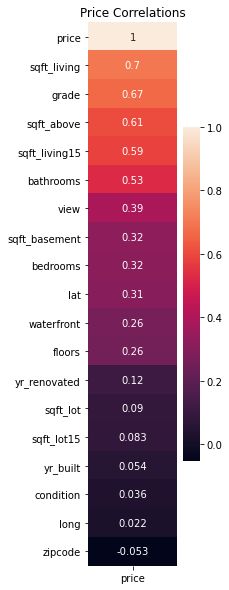

In [15]:
#Create a single-column DataFrame for price that containts its pearson correlation values; sort it descending
Corr = housing.corr()
Corr_price = pd.DataFrame(Corr['price'])
Corr_price.sort_values('price', ascending = False, inplace = True)

#Create heatmap to represent driving values:
fig = plt.figure(figsize=(2,10))
sns.heatmap(Corr_price, annot=True)
plt.title("Price Correlations")

In [16]:
housing.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

1. sqft_living correlates with sqft_above, grade, sqft_living15, and bathrooms

2. sqft_above correlates with sqft_living, and grade

3. grade correlates with sqft_living and sqft_above

4. bathrooms correlates with sqft_living

date

price

bedrooms

bathrooms

sqft_living

sqft_lot

floors

waterfront

view

condition

grade

sqft_above

sqft_basement

yr_built

yr_renovated

zipcode

lat

long

sqft_living15

sqft_lot15

housing1 will be a df that contains all possible non-colinear features if we remove sqft_living and grade. 
housing2 will be a df that contains all possible non-colinear features if we remove sqft_above, sqft_living15, grade, and bathrooms

housing1 = all features minus sqft_living & grade

housing 2 = all features minus sqft_above, sqft_living15, grade, and bathrooms 

In [17]:
housing1 = housing.drop('sqft_living', axis = 1)
housing1 = housing1.drop('grade', axis = 1)
housing1.head()

,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,5650,1.0,0.0,0.0,3,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,7242,2.0,0.0,0.0,3,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,2,1.00,10000,1.0,0.0,0.0,3,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,4,3.00,5000,1.0,0.0,0.0,5,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,8080,1.0,0.0,0.0,3,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [18]:
housing2 = housing.drop('sqft_above', axis = 1)
housing2 = housing2.drop('sqft_living15', axis = 1)
housing2 = housing2.drop('grade', axis = 1)
housing2 = housing2.drop('bathrooms', axis = 1)

In [19]:
housing2.head()

,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_lot15
0,2014-10-13,221900.0,3,1180,5650,1.0,0.0,0.0,3,0.0,1955,0.0,98178,47.5112,-122.257,5650
1,2014-12-09,538000.0,3,2570,7242,2.0,0.0,0.0,3,400.0,1951,1991.0,98125,47.7210,-122.319,7639
2,2015-02-25,180000.0,2,770,10000,1.0,0.0,0.0,3,0.0,1933,0.0,98028,47.7379,-122.233,8062
3,2014-12-09,604000.0,4,1960,5000,1.0,0.0,0.0,5,910.0,1965,0.0,98136,47.5208,-122.393,5000
4,2015-02-18,510000.0,3,1680,8080,1.0,0.0,0.0,3,0.0,1987,0.0,98074,47.6168,-122.045,7503


Because sqft_living correlates most strongly with price, I will explore the df that includes it (housing2) first. 

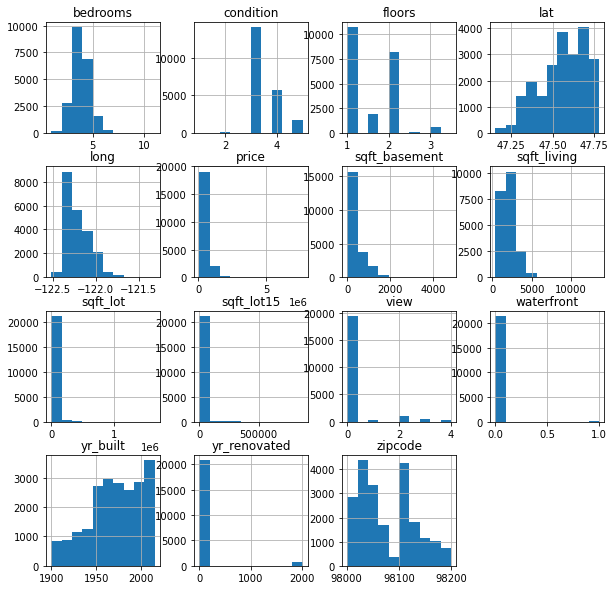

In [20]:
housing2.hist(figsize = (10,10))
plt.show()

In [21]:
#taking a sanity check for colinearity amongst the new dataset: 

df=housing2.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns into a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc <1.1)]

,cc
pairs,
"(price, price)",1.0


As expected, all modes of colinearity have been eliminated. 

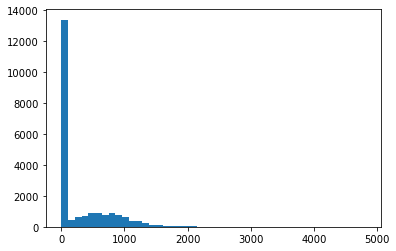

In [22]:
#first examining sqft_basement
plt.hist(housing2['sqft_basement'],bins = 45)
plt.show()

as expected, many basement values are 0. Insteaad of dealing with this as a linear variable, I will break this feature into two sections: basement and no basement. 

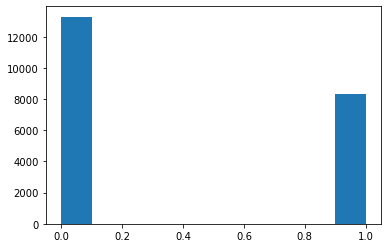

In [23]:
#to demonstrate that the basement has become a binary indicator: 
housing2['basement'] = housing2['sqft_basement'].map(lambda x: 0 if x == 0 else 1)
housing2.drop('sqft_basement', axis = 1, inplace = True)
plt.hist(housing2['basement'])
plt.show()

Other suspected categorical variables include: 

condition

floors

view

waterfront

I will check their unique values and then created dummy variables from them.

In [24]:
housing2.condition.unique()

array([3, 5, 4, 1, 2])

In [25]:
housing2.floors.unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [26]:
housing2.view.unique()

array([0., 3., 4., 2., 1.])

In [27]:
housing2.waterfront.unique()

array([0., 1.])

In [28]:
condition_dummies = pd.get_dummies(housing2['condition'], prefix='cond', drop_first=True)
floors_dummies = pd.get_dummies(housing2['floors'], prefix='floors', drop_first=True)
view_dummies = pd.get_dummies(housing2['view'], prefix='view', drop_first=True)
waterfront_dummies = pd.get_dummies(housing2['waterfront'], prefix='wf', drop_first=True)

In [29]:
housing2 = pd.concat([housing2, condition_dummies, floors_dummies, view_dummies, waterfront_dummies], axis=1)

In [30]:
housing2.head()

,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,yr_built,...,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,view_1.0,view_2.0,view_3.0,view_4.0,wf_1.0
0,2014-10-13,221900.0,3,1180,5650,1.0,0.0,0.0,3,1955,...,0,0,0,0,0,0,0,0,0,0
1,2014-12-09,538000.0,3,2570,7242,2.0,0.0,0.0,3,1951,...,0,1,0,0,0,0,0,0,0,0
2,2015-02-25,180000.0,2,770,10000,1.0,0.0,0.0,3,1933,...,0,0,0,0,0,0,0,0,0,0
3,2014-12-09,604000.0,4,1960,5000,1.0,0.0,0.0,5,1965,...,0,0,0,0,0,0,0,0,0,0
4,2015-02-18,510000.0,3,1680,8080,1.0,0.0,0.0,3,1987,...,0,0,0,0,0,0,0,0,0,0


In [31]:
housing2.columns

Index(['date', 'price', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_lot15', 'basement', 'cond_2', 'cond_3',
       'cond_4', 'cond_5', 'floors_1.5', 'floors_2.0', 'floors_2.5',
       'floors_3.0', 'floors_3.5', 'view_1.0', 'view_2.0', 'view_3.0',
       'view_4.0', 'wf_1.0'],
      dtype='object')

In [32]:
housing2.shape

(21597, 30)

Because latitude has a fairly strong correlation to price, I may choose to include it in the model. Before doing so, I will transform it into something applicable. I will replace latitude with a count of distance in miles from downtown Seattle, where property prices are highest per square foot. 

In [33]:
#pip install geopy

In [34]:
import geopy.distance

coords_1 = (47.5112, -122.257)
coords_2 = (47.6050, -122.3344)

geopy.distance.geodesic(coords_1, coords_2).miles

7.422543924237381

In [35]:
def calculate_distance_from_dt(lat, long):
    coords_1 = (lat, long)
    coords_2 = (47.6050, -122.3344)
    return geopy.distance.geodesic(coords_1, coords_2).miles

In [36]:
distances = []

for latitude, longitude in zip(housing2['lat'], housing2['long']):
    my_distance = calculate_distance_from_dt(latitude, longitude)
    distances.append(my_distance)

In [37]:
housing2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          21597 non-null  datetime64[ns]
 1   price         21597 non-null  float64       
 2   bedrooms      21597 non-null  int64         
 3   sqft_living   21597 non-null  int64         
 4   sqft_lot      21597 non-null  int64         
 5   floors        21597 non-null  float64       
 6   waterfront    21597 non-null  float64       
 7   view          21597 non-null  float64       
 8   condition     21597 non-null  int64         
 9   yr_built      21597 non-null  int64         
 10  yr_renovated  21597 non-null  float64       
 11  zipcode       21597 non-null  int64         
 12  lat           21597 non-null  float64       
 13  long          21597 non-null  float64       
 14  sqft_lot15    21597 non-null  int64         
 15  basement      21597 non-null  int64 

In [38]:
housing2['distances'] = distances
housing2.head()

,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,yr_built,...,floors_2.0,floors_2.5,floors_3.0,floors_3.5,view_1.0,view_2.0,view_3.0,view_4.0,wf_1.0,distances
0,2014-10-13,221900.0,3,1180,5650,1.0,0.0,0.0,3,1955,...,0,0,0,0,0,0,0,0,0,7.422544
1,2014-12-09,538000.0,3,2570,7242,2.0,0.0,0.0,3,1951,...,1,0,0,0,0,0,0,0,0,8.046186
2,2015-02-25,180000.0,2,770,10000,1.0,0.0,0.0,3,1933,...,0,0,0,0,0,0,0,0,0,10.329114
3,2014-12-09,604000.0,4,1960,5000,1.0,0.0,0.0,5,1965,...,0,0,0,0,0,0,0,0,0,6.430056
4,2015-02-18,510000.0,3,1680,8080,1.0,0.0,0.0,3,1987,...,0,0,0,0,0,0,0,0,0,13.544634


In [39]:
#to drop view, condition, floors, and lat:
housing2.drop(['view', 'condition', 
                'floors', 'lat'], axis=1, inplace=True)

In [40]:
#to drop waterfont: 
housing2.drop(['waterfront'], axis = 1, inplace = True)

In [41]:
#to drop date: 
housing2.drop(['date'], axis = 1, inplace = True)

In [42]:
housing2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         21597 non-null  float64
 1   bedrooms      21597 non-null  int64  
 2   sqft_living   21597 non-null  int64  
 3   sqft_lot      21597 non-null  int64  
 4   yr_built      21597 non-null  int64  
 5   yr_renovated  21597 non-null  float64
 6   zipcode       21597 non-null  int64  
 7   long          21597 non-null  float64
 8   sqft_lot15    21597 non-null  int64  
 9   basement      21597 non-null  int64  
 10  cond_2        21597 non-null  uint8  
 11  cond_3        21597 non-null  uint8  
 12  cond_4        21597 non-null  uint8  
 13  cond_5        21597 non-null  uint8  
 14  floors_1.5    21597 non-null  uint8  
 15  floors_2.0    21597 non-null  uint8  
 16  floors_2.5    21597 non-null  uint8  
 17  floors_3.0    21597 non-null  uint8  
 18  floors_3.5    21597 non-nu

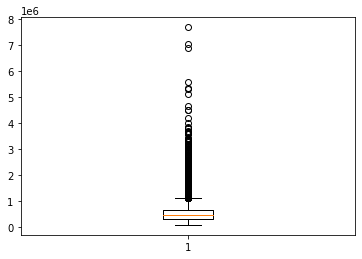

In [43]:
#checking for significant outliers:
plt.boxplot(housing2['price'])
plt.show()

In [44]:
#creating a duplicate df from housing2 and eliminating housing prices over $1m: 
housing2_dup = housing2
housing2_dup = housing2_dup[housing2_dup.price <= 1000000]

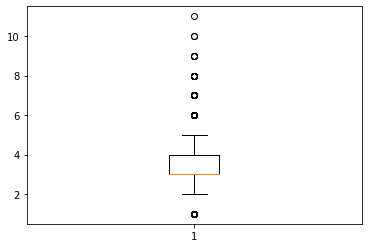

In [45]:
plt.boxplot(housing2_dup['bedrooms'])
plt.show()

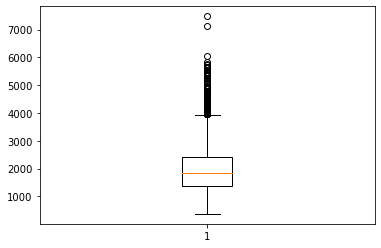

In [46]:
plt.boxplot(housing2_dup['sqft_living'])
plt.show()

In [47]:
#eliminating bedrooms over 5 and sqft_living over 4200:
housing2_dup = housing2_dup[housing2_dup.bedrooms <= 5]
housing2_dup = housing2_dup[housing2_dup.sqft_living <= 4200]


In [48]:
housing2.columns

Index(['price', 'bedrooms', 'sqft_living', 'sqft_lot', 'yr_built',
       'yr_renovated', 'zipcode', 'long', 'sqft_lot15', 'basement', 'cond_2',
       'cond_3', 'cond_4', 'cond_5', 'floors_1.5', 'floors_2.0', 'floors_2.5',
       'floors_3.0', 'floors_3.5', 'view_1.0', 'view_2.0', 'view_3.0',
       'view_4.0', 'wf_1.0', 'distances'],
      dtype='object')

In [49]:
housing2_dup.columns = ['price', 'bedrooms', 'sqft_living', 'sqft_lot', 'yr_built',
       'yr_renovated', 'zipcode', 'long', 'sqft_lot15', 'basement', 'cond2',
       'cond3', 'cond4', 'cond5', 'floors1p5', 'floors2', 'floors2p5',
       'floors3', 'floors3p5', 'view1', 'view2', 'view3',
       'view4', 'wf1', 'distances']

In [50]:
model1 = ols(formula = 'price ~ bedrooms+sqft_living+basement+wf1+distances', data=housing2_dup).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     4919.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:13:12   Log-Likelihood:            -2.6051e+05
No. Observations:               19748   AIC:                         5.210e+05
Df Residuals:                   19742   BIC:                         5.211e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.147e+05   4049.276     77.711      0.000    3.07e+05    3.23e+05
bedrooms    -2.391e+04   1428.544    -16.735      0.000   -2.67e+04   -2.11e+04
sqft_living   205.7371      1.654    124.350      0.000     202.494     208.980
basement    -3.088e+04   2038.838    -15.145      0.000   -3.49e+04   -2.69e+04
wf1          2.078e+05   1.88e+04     11.076      0.000    1.71e+05    2.45e+05
distances   -1.331e+04    148.110    -89.896      0.000   -1.36e+04    -1.3e+04
==============================================================================
Omnibus:                      348.911   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.714
Skew:                           0.291   Prob(JB):                     1.44e-85
Kurtosis:                       3.369   Cond. No.                     4.17e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
#adding in view values, and sqft_lot:
model2 = ols(formula = 'price ~ bedrooms+sqft_living+sqft_lot+basement+wf1+distances+view1+view2+view3+view4', data=housing2_dup).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     2630.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:13:13   Log-Likelihood:            -2.6014e+05
No. Observations:               19748   AIC:                         5.203e+05
Df Residuals:                   19737   BIC:                         5.204e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.134e+05   3976.501     78.824      0.000    3.06e+05    3.21e+05
bedrooms    -1.963e+04   1410.883    -13.911      0.000   -2.24e+04   -1.69e+04
sqft_living   197.0899      1.655    119.093      0.000     193.846     200.334
sqft_lot        0.4433      0.024     18.314      0.000       0.396       0.491
basement    -3.497e+04   2012.075    -17.380      0.000   -3.89e+04    -3.1e+04
wf1          7.067e+04   2.11e+04      3.351      0.001    2.93e+04    1.12e+05
distances   -1.379e+04    149.224    -92.381      0.000   -1.41e+04   -1.35e+04
view1        5.101e+04   8104.447      6.293      0.000    3.51e+04    6.69e+04
view2        6.401e+04   4842.562     13.217      0.000    5.45e+04    7.35e+04
view3        6.146e+04   7448.529      8.251      0.000    4.69e+04    7.61e+04
view4        1.582e+05   1.33e+04     11.884      0.000    1.32e+05    1.84e+05
==============================================================================
Omnibus:                      264.394   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.017
Skew:                           0.240   Prob(JB):                     7.11e-66
Kurtosis:                       3.368   Cond. No.                     1.03e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

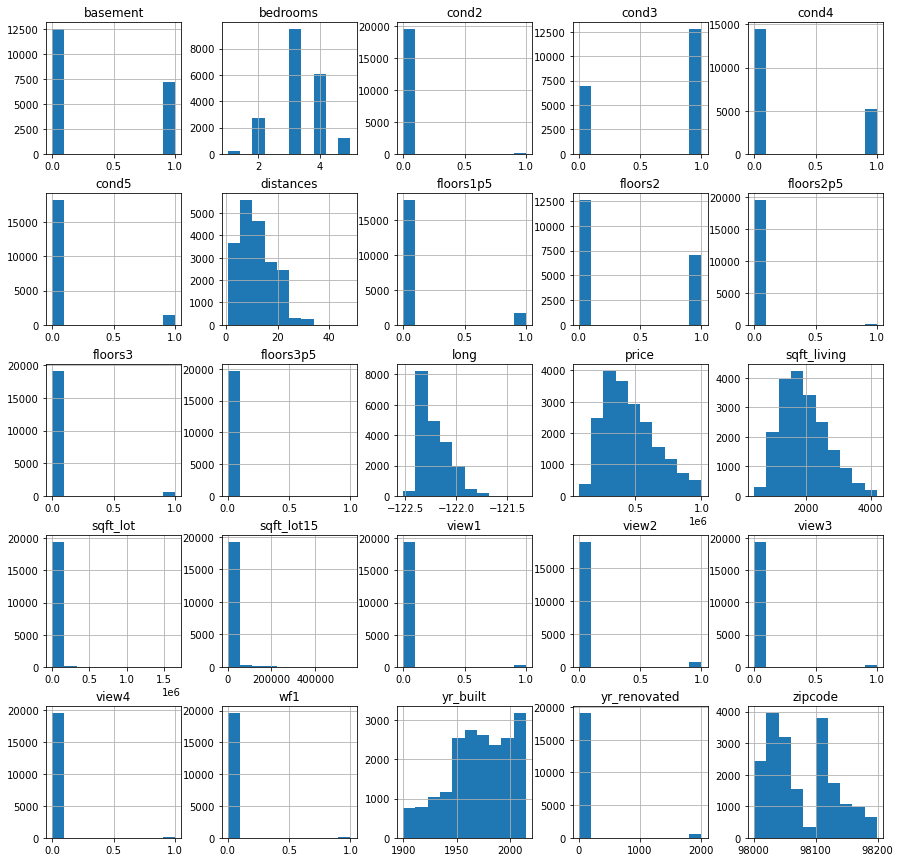

In [52]:
housing2_dup.hist(figsize = (15,15))
plt.show()

In [53]:
#eliminating sqft_lot
model3 = ols(formula = 'price ~ bedrooms+sqft_living+basement+wf1+distances+view1+view2+view3+view4', data=housing2_dup).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     2837.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:13:15   Log-Likelihood:            -2.6030e+05
No. Observations:               19748   AIC:                         5.206e+05
Df Residuals:                   19738   BIC:                         5.207e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.125e+05   4009.733     77.944      0.000    3.05e+05     3.2e+05
bedrooms     -2.18e+04   1417.744    -15.376      0.000   -2.46e+04    -1.9e+04
sqft_living   200.6973      1.657    121.120      0.000     197.449     203.945
basement    -3.494e+04   2029.046    -17.220      0.000   -3.89e+04    -3.1e+04
wf1          7.688e+04   2.13e+04      3.616      0.000    3.52e+04    1.19e+05
distances   -1.319e+04    146.841    -89.810      0.000   -1.35e+04   -1.29e+04
view1        5.147e+04   8172.770      6.297      0.000    3.54e+04    6.75e+04
view2        6.726e+04   4880.130     13.782      0.000    5.77e+04    7.68e+04
view3        7.202e+04   7488.800      9.618      0.000    5.73e+04    8.67e+04
view4        1.577e+05   1.34e+04     11.750      0.000    1.31e+05    1.84e+05
==============================================================================
Omnibus:                      309.979   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.069
Skew:                           0.268   Prob(JB):                     1.59e-76
Kurtosis:                       3.370   Cond. No.                     5.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
#eliminating views, and keeping sqft_lot
model4 = ols(formula = 'price ~ bedrooms+sqft_living+sqft_lot+basement+wf1+distances', data=housing2_dup).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     4237.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:13:15   Log-Likelihood:            -2.6033e+05
No. Observations:               19748   AIC:                         5.207e+05
Df Residuals:                   19741   BIC:                         5.207e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.156e+05   4012.393     78.648      0.000    3.08e+05    3.23e+05
bedrooms    -2.148e+04   1421.080    -15.114      0.000   -2.43e+04   -1.87e+04
sqft_living   201.6080      1.653    121.937      0.000     198.367     204.849
sqft_lot        0.4674      0.024     19.192      0.000       0.420       0.515
basement    -3.115e+04   2020.179    -15.417      0.000   -3.51e+04   -2.72e+04
wf1          2.002e+05   1.86e+04     10.766      0.000    1.64e+05    2.37e+05
distances   -1.394e+04    150.352    -92.730      0.000   -1.42e+04   -1.36e+04
==============================================================================
Omnibus:                      291.965   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.176
Skew:                           0.259   Prob(JB):                     5.46e-72
Kurtosis:                       3.362   Cond. No.                     8.45e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So far, the strongest model occurs when I incorporate both views and sqft_lot. 

In [74]:
#floors1p5+floors2+floors2p5+floors3+floors3p5

#adding in floors to strongest model:
model = ols(formula = 'price ~ bedrooms+sqft_living+sqft_lot+basement+wf1+distances', data=housing2_dup).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     4237.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:13:58   Log-Likelihood:            -2.6033e+05
No. Observations:               19748   AIC:                         5.207e+05
Df Residuals:                   19741   BIC:                         5.207e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.156e+05   4012.393     78.648      0.000    3.08e+05    3.23e+05
bedrooms    -2.148e+04   1421.080    -15.114      0.000   -2.43e+04   -1.87e+04
sqft_living   201.6080      1.653    121.937      0.000     198.367     204.849
sqft_lot        0.4674      0.024     19.192      0.000       0.420       0.515
basement    -3.115e+04   2020.179    -15.417      0.000   -3.51e+04   -2.72e+04
wf1          2.002e+05   1.86e+04     10.766      0.000    1.64e+05    2.37e+05
distances   -1.394e+04    150.352    -92.730      0.000   -1.42e+04   -1.36e+04
==============================================================================
Omnibus:                      291.965   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.176
Skew:                           0.259   Prob(JB):                     5.46e-72
Kurtosis:                       3.362   Cond. No.                     8.45e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

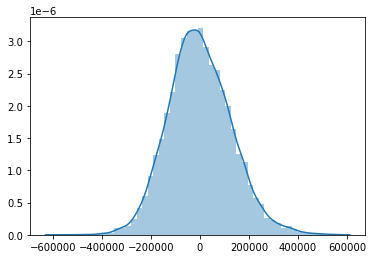

In [56]:
#deciding to use the last model with strongest r-squared- testing residuals
sns.distplot(model.resid)
plt.show()


In [57]:
#bedrooms+sqft_living+sqft_lot+basement+wf1+distances+view1
#+view2+view3+view4+floors1p5+floors2+floors2p5+floors3+floors3p5
model_predictors = pd.DataFrame([])
model_predictors['bedrooms'] = housing2_dup['bedrooms']
model_predictors['sqft_living'] = housing2_dup['sqft_living']
model_predictors['sqft_lot'] = housing2_dup['sqft_lot']
model_predictors['basement'] = housing2_dup['basement']
model_predictors['wf1'] = housing2_dup['wf1']
model_predictors['distances'] = housing2_dup['distances']
#model_predictors['view1'] = housing2_dup['view1']
#model_predictors['view2'] = housing2_dup['view2']
#model_predictors['view3'] = housing2_dup['view3']
#model_predictors['view4'] = housing2_dup['view4']
#model_predictors['floors1p5'] = housing2_dup['floors1p5']
#model_predictors['floors2'] = housing2_dup['floors2']
#model_predictors['floors2p5'] = housing2_dup['floors2p5']
#model_predictors['floors3'] = housing2_dup['floors3']
#model_predictors['floors3p5'] = housing2_dup['floors3p5']



In [58]:
#Storing good model in the variable modelF
linreg=LinearRegression()
model = linreg.fit(model_predictors, housing2_dup['price'])

#Create dictionary matching variable names to their corresponding coeffs
var_coefs = dict(zip(model_predictors.columns, model.coef_))

#Display variable names and coeffs
var_coefs

{'bedrooms': -21478.165023930826,
 'sqft_living': 201.6079551350874,
 'sqft_lot': 0.46740707381197283,
 'basement': -31145.038014409038,
 'wf1': 200190.0654483815,
 'distances': -13942.229440606074}

In [59]:
model.intercept_

315566.002035358

In [60]:
model_predictors.head()

,bedrooms,sqft_living,sqft_lot,basement,wf1,distances
0,3,1180,5650,0,0,7.422544
1,3,2570,7242,1,0,8.046186
2,2,770,10000,0,0,10.329114
3,4,1960,5000,1,0,6.430056
4,3,1680,8080,0,0,13.544634


In [61]:
housing_fin = pd.concat([model_predictors, housing2_dup['price']], axis = 1)
housing_fin.head()

,bedrooms,sqft_living,sqft_lot,basement,wf1,distances,price
0,3,1180,5650,0,0,7.422544,221900.0
1,3,2570,7242,1,0,8.046186,538000.0
2,2,770,10000,0,0,10.329114,180000.0
3,4,1960,5000,1,0,6.430056,604000.0
4,3,1680,8080,0,0,13.544634,510000.0


In [62]:
def price_prediction():
   
    price = model.intercept_
    
#bedroom value     
    bedrooms = input("Number of bedrooms? ")
    bedroom_v = var_coefs['bedrooms'] * (float(bedrooms))
    price += bedroom_v
    
#indoor squarefoot value 
    sqft_living = input("Number of indoor square feet?")
    sqft_living_v = var_coefs['sqft_living'] * (float(sqft_living))
    price += sqft_living_v

#outdoor sqarefoot value 
    sqft_lot = input("Number of outdoor square feet?")
    sqft_lot_v = var_coefs['sqft_lot'] * (float(sqft_lot))
    price += sqft_lot_v

#Basement value 
    basement = input("Is there a basement? 1=yes, 0=no")
    basement_v = var_coefs['basement'] * (float(basement))
    price += basement_v

#Waterfront value 
    waterfront = input("Is the property waterfront? 1=yes, 0=no")
    waterfront_v = var_coefs['wf1'] * (float(waterfront))
    price += waterfront_v

#Distance from city center 
    distance = input("How many miles from downtown?  ")
    distance_v = var_coefs['distances'] * (float(distance))
    price += distance_v
    
   

#views
    #view = int(input("How many times has the property been viewed? (1-4)"))
    #if view == 1:
         #view_v = var_coefs['view1']
    #if view == 2:
        #view_v = var_coefs['view2']
    #if view == 3:
        #view_v = var_coefs['view3']
    #if view == 4:
       # view_v = var_coefs['view4']
    #else:
        #view_v == 0
        
        #price += view_v

#floors
    #floors = int(input("How many floors does this property have? (1 - 3)  "))
    #if floors == 1.5:
       # floors_v = var_coefs['floors1p5']
    #if floors == 2:
        #floors_v = var_coefs['floors2']
    #if floors == 2.5:
        #floors_v = var_coefs['floors2p5']
    #if floors == 3:
        #floors_v = var_coefs['floors3']
    #if floors == 3.5:
        #floors_v = var_coefs['floors3p5']
    #else:
        #floors_v = 0
        
        #price += floors_v
    
    
    return 'The total property value is ${}'.format(round(price, 0))

In [63]:
price_prediction() 

Number of bedrooms? 2
Number of indoor square feet?3
Number of outdoor square feet?4
Is there a basement? 1=yes, 0=no1
Is the property waterfront? 1=yes, 0=no1
How many miles from downtown?  4


'The total property value is $386492.0'

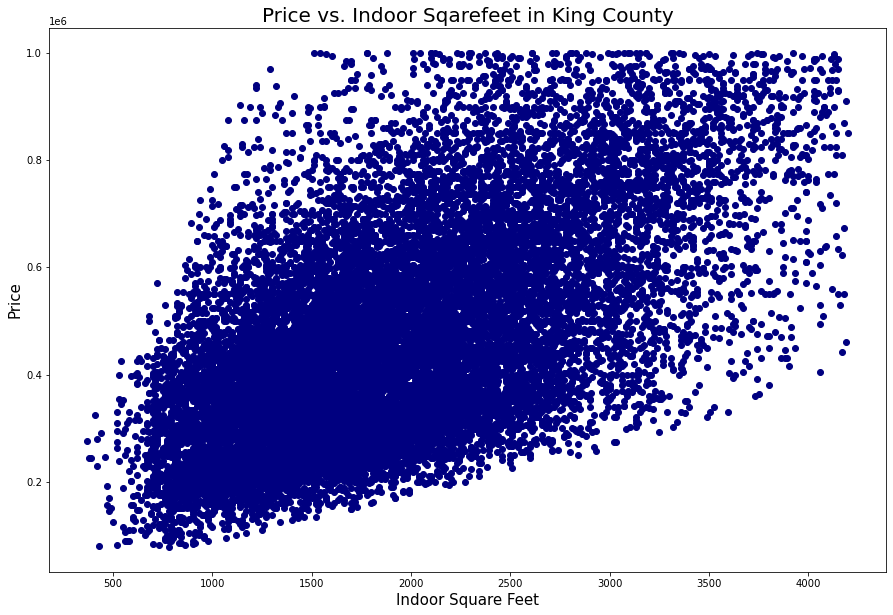

In [64]:
# Data for plotting
s = housing2_dup['sqft_living']
p = housing2_dup['price']

plt.figure(figsize=(15,10))
plt.scatter(s, p, color = 'navy')
plt.title('Price vs. Indoor Sqarefeet in King County', size = 20)
plt.ylabel('Price', size = 15)
plt.xlabel('Indoor Square Feet', size = 15)





plt.show()

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]),
 <a list of 10 Text major ticklabel objects>)

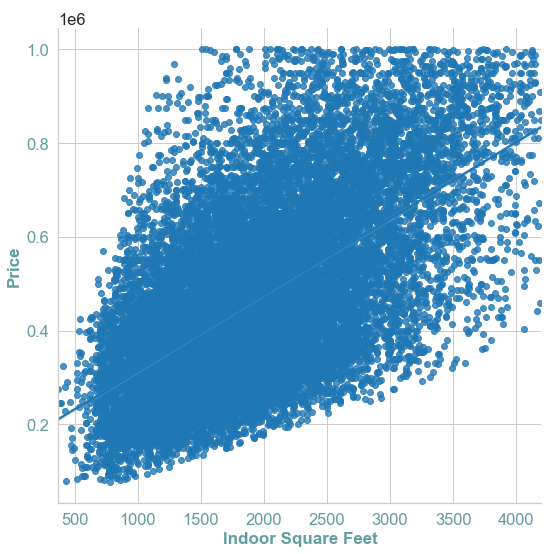

In [65]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)
sns.lmplot(x='sqft_living', y='price', data=housing2_dup, fit_reg=True, legend=True, palette="cadetblue", height=(8))
plt.xlabel('Indoor Square Feet', fontweight='bold', color = 'cadetblue', fontsize='17', horizontalalignment='center')
plt.ylabel('Price', fontweight='bold', color = 'cadetblue', fontsize='17', horizontalalignment='center')
plt.title('Price vs. Indoor Square Feet in King County', fontweight='bold', color = 'white', fontsize='20')
plt.yticks(color='cadetblue')
plt.xticks(color='cadetblue')

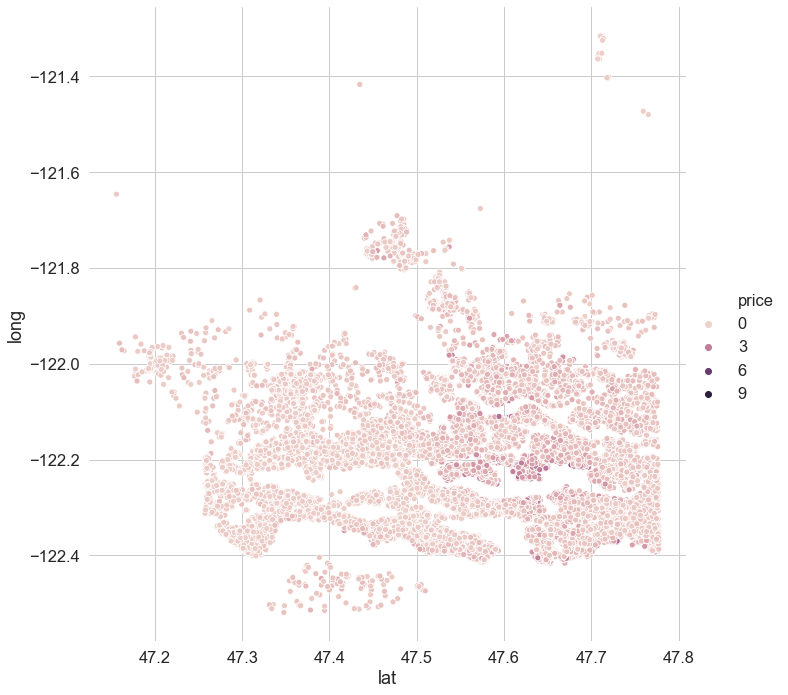

In [66]:
sns.set_style("whitegrid")

# Load the example planets dataset

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=housing,
    x="lat", y="long",
    hue="price", height = 10)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

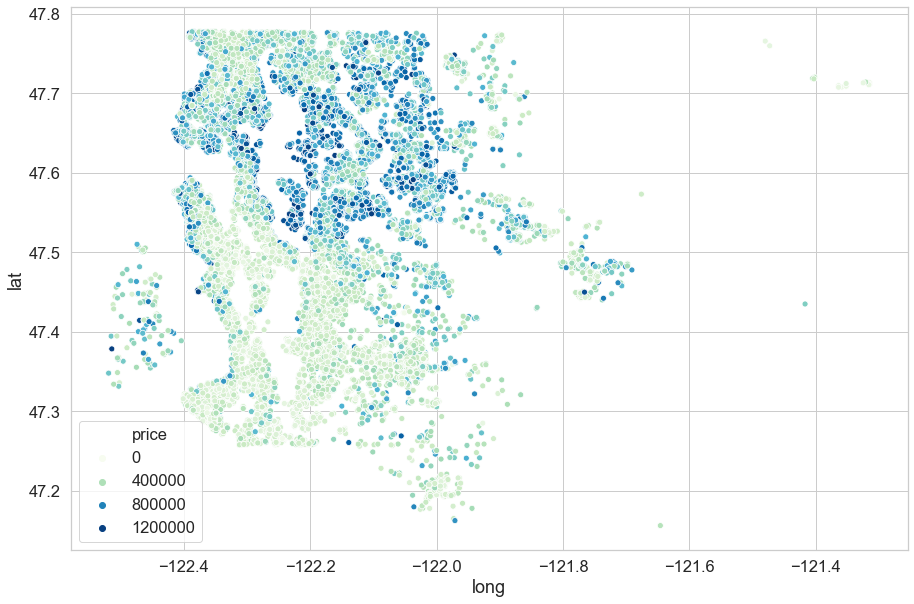

In [67]:
#sns.scatterplot(x=housing.long, y=housing.lat), color = 'lightgrey', size=10)


plt.figure(figsize=(15, 10))
sns.scatterplot(x=housing.long, y=housing.lat, hue=housing2_dup['price'], palette='GnBu')
plt.show()

<Figure size 720x720 with 0 Axes>

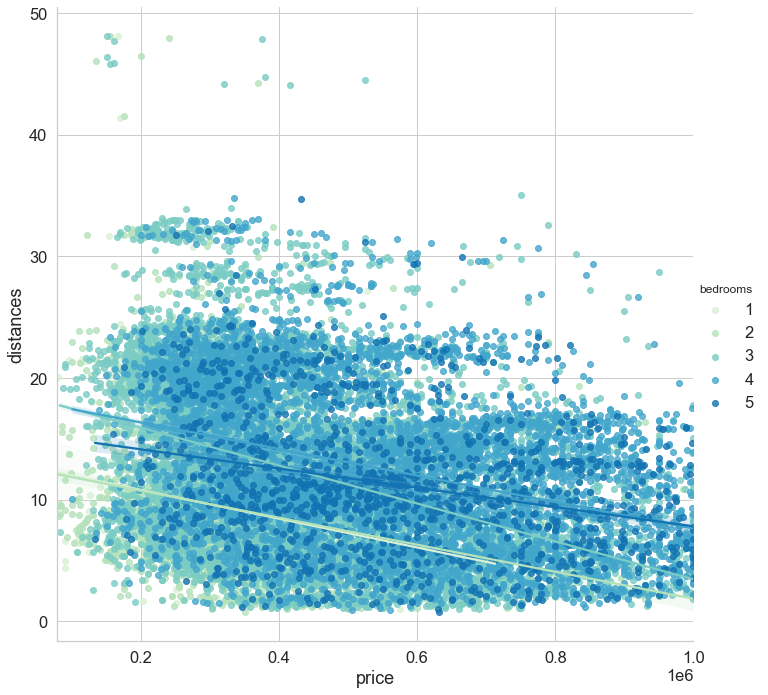

In [68]:
#sns.scatterplot(x=housing.long, y=housing.lat), color = 'lightgrey', size=10)

plt.figure(figsize=(10,10))
sns.lmplot(x='price', y='distances', hue='bedrooms', data=housing2_dup, fit_reg=True, palette='GnBu', height=(10))
plt.show()

In [69]:
housing2_dup['bedrooms'].unique()

array([3, 2, 4, 5, 1])

<Figure size 720x720 with 0 Axes>

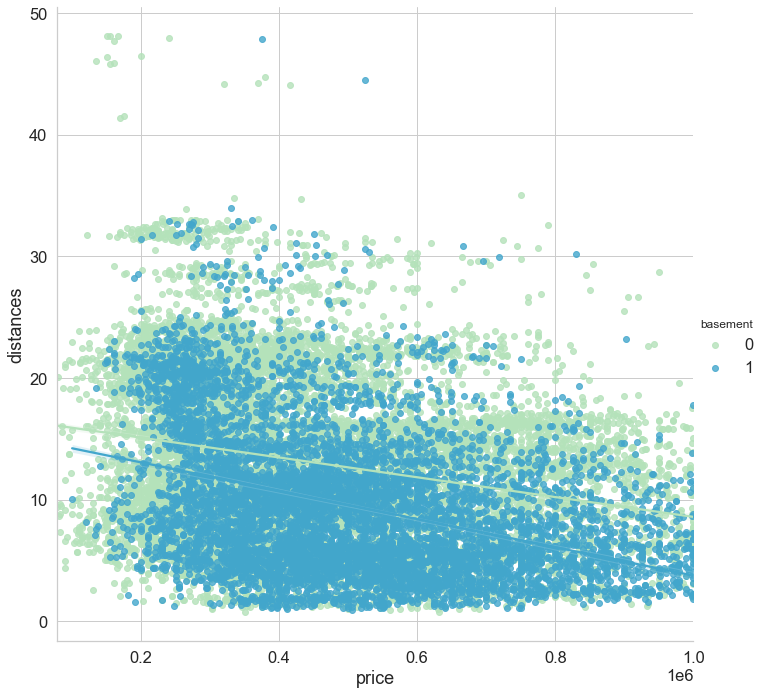

In [70]:
plt.figure(figsize=(10,10))
sns.lmplot(x='price', y='distances', hue='basement', data=housing2_dup, fit_reg=True, palette='GnBu', height=(10))
plt.show()

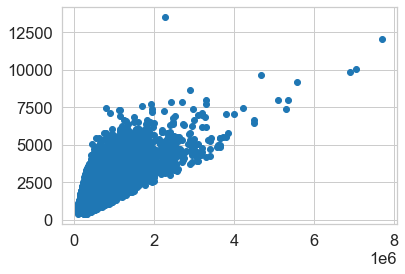

In [71]:

x = housing['sqft_living']
y = housing['price']

plt.scatter(y, x)
plt.show()

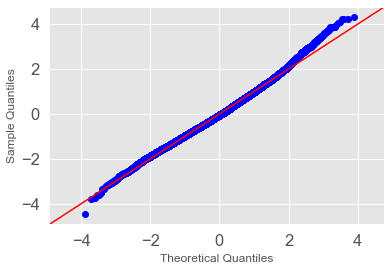

In [75]:

plt.style.use('ggplot')

f = 'price ~ bedrooms+sqft_living+sqft_lot+basement+wf1+distances'

resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)



In [76]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)

lzip(names, test)


[('Lagrange multiplier statistic', 854.6567334567831),
 ('p-value', 2.377795030292874e-181),
 ('f-value', 148.83353656317757),
 ('f p-value', 2.029931101876485e-185)]

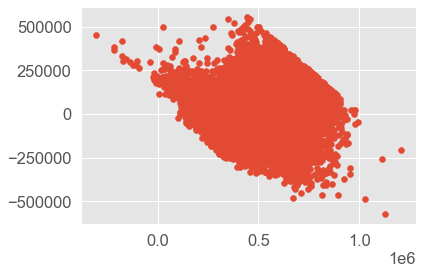

In [78]:
plt.scatter(model.fittedvalues, model.resid)

In [ ]:
#null hypothesis- homoskedasity is present 
#alternative hypothesis - homoskedasity is not present 

#p-value is not less than 0.05, so I fail to reject the null hypothesis and conclude that heteroskedasity is 
#not present. 